In [90]:
%reload_ext autoreload
%autoreload 2
from kdephys.xr import xr_flavor_da, xr_flavor_ds
import kdephys.xr as kx
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from kdephys.plot.main import *
from kdephys.plot.units import *
import yaml
import math
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_continuous.mplstyle')

In [72]:
subject = 'ACR_25'
exp = 'swi'
stores = ['NNXr', 'NNXo']
sort_ids = [f'{exp}-{store}' for store in stores]
chans = [2, 9, 16] # represents one superficial, middle, and deep channel to be used in the analysis

recordings = acr.info_pipeline.get_exp_recs(subject, exp)
stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
t_on, t_off = acr.stim.get_pulse_train_times(subject, exp, 'Pu1_')
pon, poff = acr.stim.get_individual_pulse_times(subject, exp, 'Pu1_')

In [73]:
# Load the bandpower and hypnogram data
#bp = acr.io.load_concat_bandpower(subject, recordings, stores);
#bp_rel = kx.utils.rel_by_store(bp, exp);
h = acr.io.load_hypno_full_exp(subject, exp); # load hypnogram for experiment

In [74]:
lfp = acr.io.load_concat_raw_data(subject, [exp], stores)

/home/kdriessen/miniconda3/envs/acr_bg/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr_bg/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


# One Channel Each Probe

In [101]:
train_number = 1
channel = 9
t_before = 1.2
t_stim = .140 #make sure this is right!
t_after = 1.2
sample_rate = 400
#---------------------------------------------------

tot_r = []
tot_o = []

n_samples = int((t_before + t_stim + t_after) * sample_rate)

#n_samples = n_samples + 1

train_start = t_on[train_number]
train_stop = t_off[train_number] + 1

for on, off in zip(pon[train_start:train_stop], poff[train_start:train_stop]): 
    
    t1 = pd.Timestamp(on) - pd.Timedelta(f'{t_before}s')
    t2 = pd.Timestamp(off) + pd.Timedelta(f'{t_after}s')
    vals_r = lfp.ch(channel).prb('NNXr').sel(datetime=slice(t1, t2)).values
    vals_r = vals_r[:n_samples]
    vals_o = lfp.ch(channel).prb('NNXo').sel(datetime=slice(t1, t2)).values
    vals_o = vals_o[:n_samples]
    assert len(vals_r) == n_samples, print(len(vals_r))
    assert len(vals_o) == n_samples, print(len(vals_o))
    tot_r.append(vals_r)
    tot_o.append(vals_o)
laser_on = sample_rate * t_before 
laser_off = sample_rate * (t_before + t_stim)
period = 1/sample_rate
time = np.arange(-t_before, (t_stim + t_after), period)
time = time*1000
tot_all = np.array([tot_r, tot_o])

In [102]:
std = np.std(tot_all, axis=1)
mn = np.mean(tot_all, axis=1)

print(len(time), len(mn[1]))

1016 1016


In [96]:
time = time[:-1]

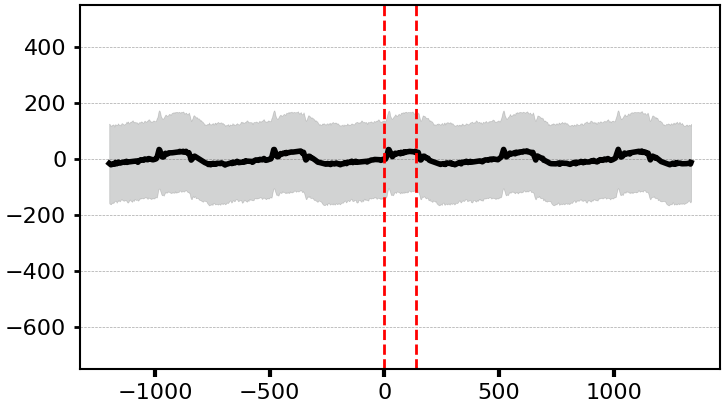

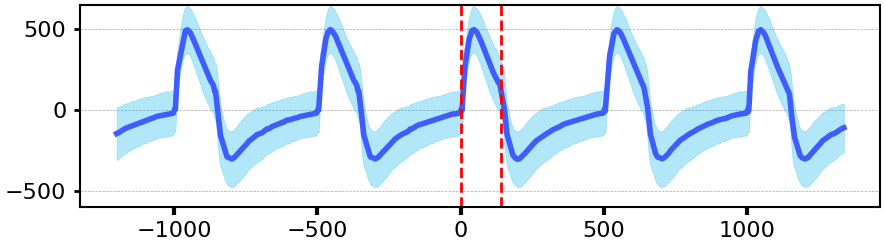

In [103]:
f, ax = plt.subplots(figsize=(16, 9))
#x = np.arange(0, len(mn))
means = mn[0, :]
stds = std[0, :]
ax.plot(time, means, color='black', linewidth=8)
ax.fill_between(time, means-stds, means+stds, color='#6c6e6e', alpha=0.3)
ax.axvline(0, color='red', linestyle='--', linewidth=4)
ax.axvline(t_stim*1000, color='red', linestyle='--', linewidth=4)
ax.set_ylim(-750, 550)
#ax.set_xticklabels('')
#f.savefig(f'./plots/{subject}--NNXr--{exp}--{train_number}--avgLFP--chan-{channel}.png', dpi=300)

#---------------------------------------------------------------------------------------------------------------------------------

f, ax = plt.subplots(figsize=(20, 5))
#x = np.arange(0, len(mn))
means = mn[1, :]
stds = std[1, :]
ax.plot(time, means, color='#3F5CFC', linewidth=8)
ax.fill_between(time, means-stds, means+stds, color='#00B0F0', alpha=0.3)
ax.axvline(0, color='red', linestyle='--', linewidth=4)
ax.axvline(t_stim*1000, color='red', linestyle='--', linewidth=4)
ax.set_ylim(-600, 650)
f.savefig(f'./{subject}--NNXo--{exp}--{train_number}--avgLFP--chan-{channel}.png', dpi=300)

# ALL Channels Each Probe

In [92]:
# ALL CHANNELS
train_number = 1
#channel = 12
t_before = .150
t_stim = .140 #make sure this is right!
t_after = .150
sample_rate = 400
#---------------------------------------------------

tot_r = []
tot_o = []

n_samples = int((t_before + t_stim + t_after) * sample_rate)

train_start = t_on[train_number]
train_stop = t_off[train_number] + 1

for on, off in zip(pon[train_start:train_stop], poff[train_start:train_stop]): 
    
    t1 = pd.Timestamp(on) - pd.Timedelta(f'{t_before}s')
    t2 = pd.Timestamp(off) + pd.Timedelta(f'{t_after}s')
    #vals_r = lfp.ch(channel).prb('NNXr').sel(datetime=slice(t1, t2)).values
    #vals_r = vals_r[:n_samples+1]
    vals_o = lfp.prb('NNXo').sel(datetime=slice(t1, t2)).values
    vals_o = vals_o[:n_samples]
    #tot_r.append(vals_r)
    tot_o.append(vals_o)
laser_on = sample_rate * t_before 
laser_off = sample_rate * (t_before + t_stim)
period = 1/sample_rate
time = np.arange(-t_before, (t_stim + t_after), period)
#tot_all = np.array([tot_r, tot_o])
tot = np.array(tot_o)
std = np.std(tot, axis=0)
mn = np.mean(tot, axis=0)
time = time*1000

if len(time) > len(mn[:, 0]):
    time = time[:-1]
print(len(time), len(mn[:, 0]))

176 176


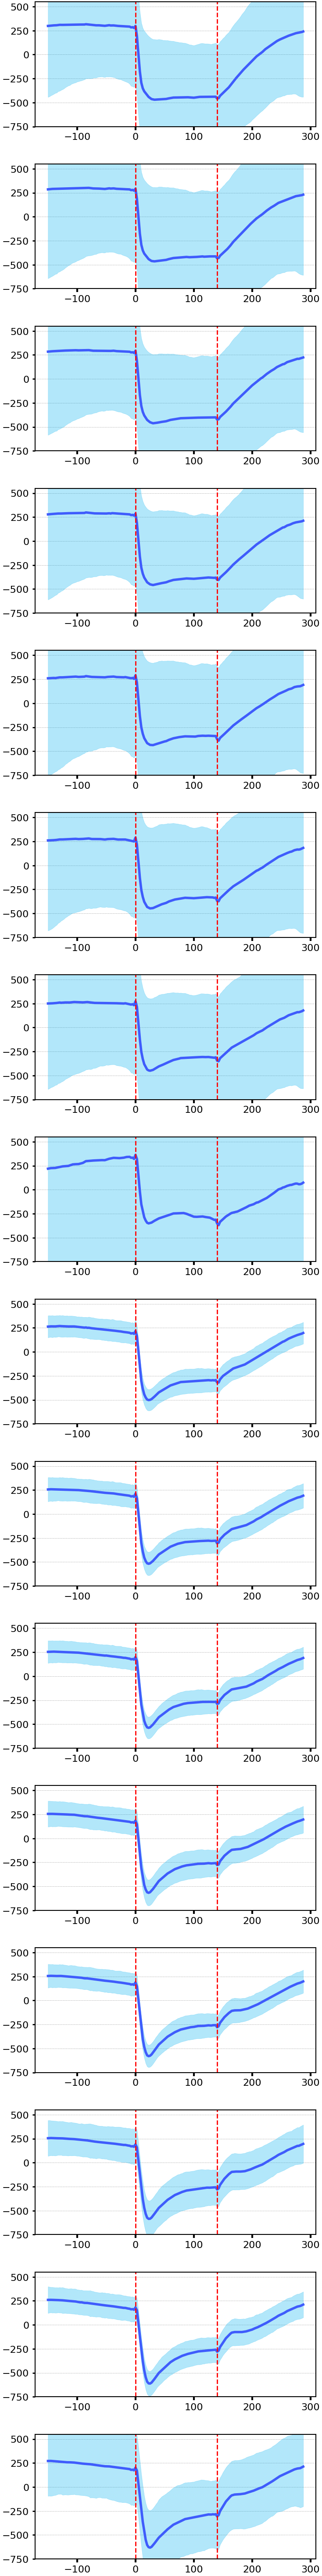

In [69]:
n_chans = mn.shape[1]
f, ax = plt.subplots(n_chans, 1, figsize=(16, 9*n_chans))

for i in np.arange(0, n_chans):
    means = mn[:, i]
    stds = std[:, i]
    ax[i].plot(time, means, color='#3F5CFC', linewidth=8)
    ax[i].fill_between(time, means-stds, means+stds, color='#00B0F0', alpha=0.3)
    ax[i].axvline(0, color='red', linestyle='--', linewidth=4)
    ax[i].axvline(t_stim*1000, color='red', linestyle='--', linewidth=4)
    ax[i].set_ylim(-750, 550)
f.savefig(f'./plots/{subject}--NNXo--{exp}--train-{train_number}--avgLFP--ALL-CHANS.png', dpi=300, bbox_inches='tight')

In [70]:
tot_probe = []

n_samples = int((t_before + t_stim + t_after) * sample_rate)

train_start = t_on[train_number]
train_stop = t_off[train_number] + 1

for on, off in zip(pon[train_start:train_stop], poff[train_start:train_stop]): 
    
    t1 = pd.Timestamp(on) - pd.Timedelta(f'{t_before}s')
    t2 = pd.Timestamp(off) + pd.Timedelta(f'{t_after}s')
    vals = lfp.prb('NNXr').sel(datetime=slice(t1, t2)).values
    vals = vals[:n_samples]
    tot_probe.append(vals)
laser_on = sample_rate * t_before 
laser_off = sample_rate * (t_before + t_stim)
period = 1/sample_rate
time = np.arange(-t_before, (t_stim + t_after), period)
#tot_all = np.array([tot_r, tot_probe])
tot = np.array(tot_probe)
std = np.std(tot, axis=0)
mn = np.mean(tot, axis=0)
time = time*1000
if len(time) > len(mn[:, 0]):
    time = time[:-1]
print(len(time), len(mn[:, 0]))

176 176


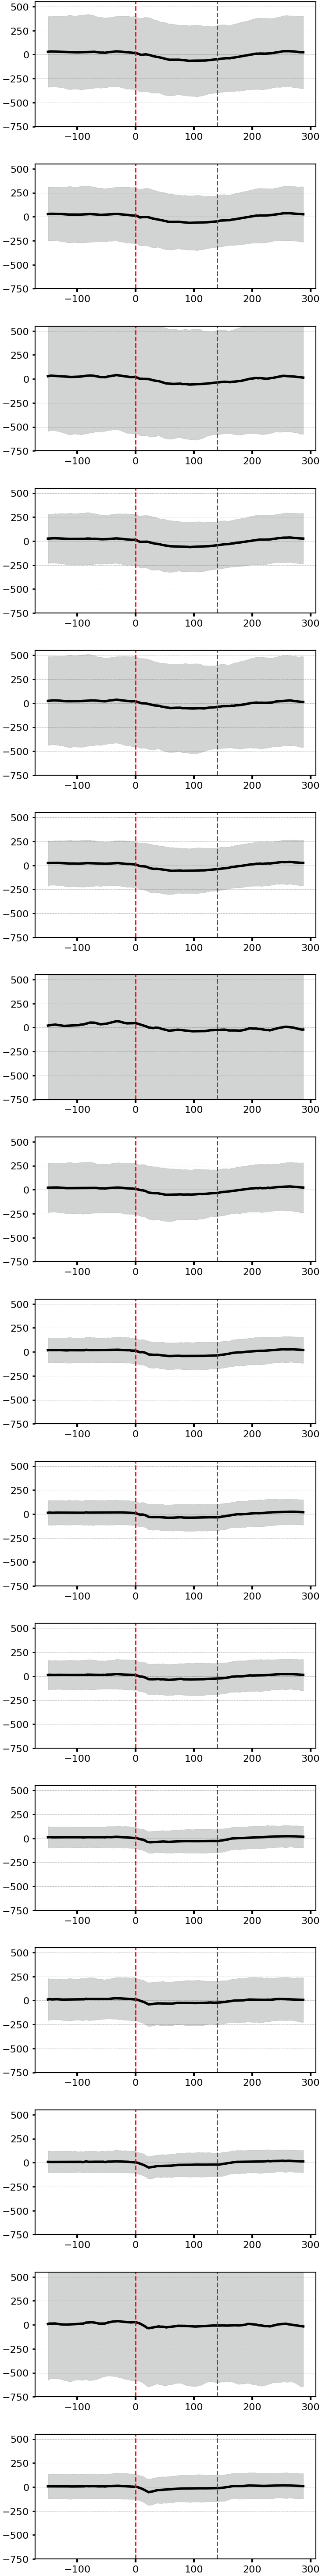

In [71]:
n_chans = mn.shape[1]
f, ax = plt.subplots(n_chans, 1, figsize=(16, 9*n_chans))

for i in np.arange(0, n_chans):
    means = mn[:, i]
    stds = std[:, i]
    ax[i].plot(time, means, color='black', linewidth=8)
    ax[i].fill_between(time, means-stds, means+stds, color='#6c6e6e', alpha=0.3)
    ax[i].axvline(0, color='red', linestyle='--', linewidth=4)
    ax[i].axvline(t_stim*1000, color='red', linestyle='--', linewidth=4)
    ax[i].set_ylim(-750, 550)
f.savefig(f'./plots/{subject}--NNXr--{exp}--train-{train_number}--avgLFP--ALL-CHANS.png', dpi=300, bbox_inches='tight')